### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score, StratifiedKFold
from sklearn.impute import KNNImputer
from sklearn.model_selection import learning_curve
from evalml import AutoMLSearch

### Load saved dataframe

In [2]:
df = pd.read_pickle('data.pkl')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype   
---  ------                                          --------------  -----   
 0   Marital status                                  4424 non-null   category
 1   Application mode                                4424 non-null   category
 2   Application order                               4424 non-null   category
 3   Course                                          4424 non-null   category
 4   Daytime/evening attendance                      4424 non-null   category
 5   Previous qualification                          4424 non-null   category
 6   Previous qualification (grade)                  4424 non-null   float64 
 7   Nationality                                     4424 non-null   category
 8   Mother_qualification                            4424 non-null   category
 9   Father_qualification          

In [4]:
df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nationality,Mother_qualification,Father_qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [5]:
# Prepare the Data
X = df.drop(columns=['Target'])  # Features
y = df['Target']  # Target variable

In [6]:
# Convert Target Variable to Numeric Labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Display the encoded labels and classes
print("Encoded Labels:", y_encoded)
print("Classes:", label_encoder.classes_)

Encoded Labels: [0 2 0 ... 0 2 2]
Classes: ['Dropout' 'Enrolled' 'Graduate']


In [7]:
y_encoded

array([0, 2, 0, ..., 0, 2, 2])

In [8]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Identify Numerical Columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Identify categorical columns
categorical_cols = X.select_dtypes(include=['category']).columns.tolist()


### Using evalml Automl to check multiple models to know potential best performing model

In [9]:
from evalml.objectives import get_all_objective_names

# List all valid objectives
print(get_all_objective_names())


['expvariance', 'maxerror', 'medianae', 'mse', 'mae', 'r2', 'mean squared log error', 'root mean squared log error', 'root mean squared error', 'symmetric mean absolute percentage error', 'mean absolute percentage error', 'mean absolute scaled error', 'mcc multiclass', 'log loss multiclass', 'auc weighted', 'auc macro', 'auc micro', 'recall weighted', 'recall macro', 'recall micro', 'precision weighted', 'precision macro', 'precision micro', 'f1 weighted', 'f1 macro', 'f1 micro', 'balanced accuracy multiclass', 'accuracy multiclass', 'mcc binary', 'log loss binary', 'gini', 'auc', 'recall', 'precision', 'f1', 'balanced accuracy binary', 'accuracy binary', 'sensitivity at low alert rates', 'lead scoring', 'fraud cost', 'cost benefit matrix']


In [10]:
# Use EvalML AutoML with default settings
automl = AutoMLSearch(X_train=X_train,
                       y_train=y_train,
                       problem_type='multiclass',
                       objective='log loss multiclass',
                       max_batches=1)

# Fit the AutoML search
automl.search()

# Get the best model
best_pipeline = automl.best_pipeline

# Display the results
print(f"Best pipeline: {best_pipeline}")
print(f"Best pipeline's performance: {automl.rankings}")

C:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
C:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
C:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
C:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\woodwork\type

Best pipeline: Random Forest Classifier w/ Label Encoder + Imputer + One Hot Encoder + RF Classifier Select From Model
Best pipeline's performance:    id                                      pipeline_name  search_order  \
0   1  Random Forest Classifier w/ Label Encoder + Im...             1   
1   0   Mode Baseline Multiclass Classification Pipeline             0   

   ranking_score  mean_cv_score  standard_deviation_cv_score  \
0       0.645856       0.645856                     0.011758   
1      18.047286      18.047286                     0.008810   

   percent_better_than_baseline  high_variance_cv  \
0                     96.421314             False   
1                      0.000000             False   

                                          parameters  
0  {'Label Encoder': {'positive_label': None}, 'I...  
1  {'Label Encoder': {'positive_label': None}, 'B...  


The **EvalML AutoML** process evaluated multiple classification pipelines and selected the Random Forest Classifier as the best model for the dataset. This pipeline includes a Label Encoder for categorical labels, an Imputer for missing values, a One Hot Encoder for categorical variables, and a feature selection step based on model importance. The chosen pipeline outperformed the baseline model by approximately 96.42%, achieving a mean cross-validation score of about 0.646. Additionally, a UserWarning was generated during date parsing, suggesting potential inconsistencies in date handling but this is not a problem looking at the dtatset carefully.
So definitely Tree based models should perform best.

### Data Preprocessing, Hyperparameter Tuning and Model Evaluation

In [11]:
# Create a Column Transformer for Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', KNNImputer(n_neighbors=5)),
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', 'passthrough', categorical_cols)
    ]
)

In [12]:
# Define Hyperparameter Search Spaces
rf_param_dist = {
    'model__n_estimators': [50, 100, 150], #[100, 200, 300]
    'model__max_depth': [None, 5, 10, 15],
    'model__min_samples_split': [4, 10, 20], #[2, 5, 10]
    'model__min_samples_leaf': [2, 4, 6], #[1, 2, 3]
    'model__bootstrap': [True, False]
}

xgb_param_dist = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [1, 2, 3],
    'model__learning_rate': [0.02, 0.2, 0.4],
    'model__subsample': [0.7, 0.8, 0.9],
    'model__colsample_bytree': [0.7, 0.8, 1.0]
}

In [13]:
# Create Pipelines
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=42))
])

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(eval_metric='mlogloss', random_state=42))
])

In [14]:
# Perform hyperparameter tuning with RandomizedSearchCV to the RandomForest pipeline
rf_random_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=rf_param_dist,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    n_iter=10,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Perform hyperparameter tuning with RandomizedSearchCV to the XGBoost pipeline
xgb_random_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=xgb_param_dist,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    n_iter=10,
    n_jobs=-1,
    verbose=1,
    random_state=42
)


In [15]:
# Train Models with Hyperparameter Tuning
rf_random_search.fit(X_train, y_train)
xgb_random_search.fit(X_train, y_train)

# Make Predictions on Test Set
rf_y_pred = rf_random_search.best_estimator_.predict(X_test)
xgb_y_pred = xgb_random_search.best_estimator_.predict(X_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [16]:
# Evaluation on Test Set
print("Random Forest Test Accuracy:", accuracy_score(y_test, rf_y_pred))
print(classification_report(y_test, rf_y_pred))

print("XGBoost Test Accuracy:", accuracy_score(y_test, xgb_y_pred))
print(classification_report(y_test, xgb_y_pred))

Random Forest Test Accuracy: 0.7796610169491526
              precision    recall  f1-score   support

           0       0.81      0.75      0.78       284
           1       0.62      0.43      0.51       159
           2       0.80      0.93      0.86       442

    accuracy                           0.78       885
   macro avg       0.74      0.70      0.71       885
weighted avg       0.77      0.78      0.77       885

XGBoost Test Accuracy: 0.7728813559322034
              precision    recall  f1-score   support

           0       0.80      0.74      0.77       284
           1       0.55      0.48      0.52       159
           2       0.82      0.90      0.86       442

    accuracy                           0.77       885
   macro avg       0.72      0.71      0.71       885
weighted avg       0.77      0.77      0.77       885



In [17]:
def plot_learning_curve(estimator, X, y, title="Learning Curve", cv=None, n_jobs=-1):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs,
        train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label="Training Score", color='blue')
    plt.plot(train_sizes, test_scores_mean, label="Cross-validation Score", color='orange')
    plt.title(title)
    plt.xlabel("Training Size")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

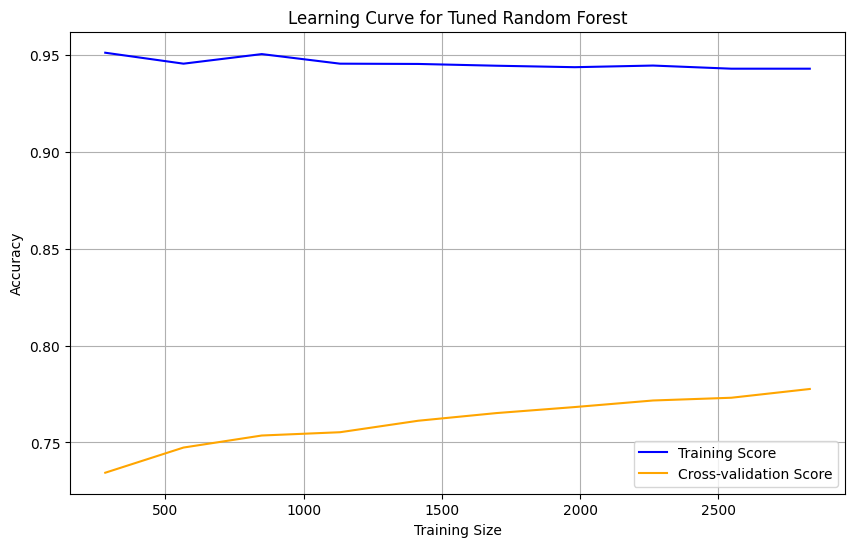

In [18]:
# Assuming rf_random_search is your tuned Random Forest model
best_rf_model = rf_random_search.best_estimator_

# Plot learning curve
plot_learning_curve(best_rf_model, X_train, y_train, title="Learning Curve for Tuned Random Forest")

In [19]:
# Assuming xgb_random_search is your tuned XGBoost model
best_xgb_model = xgb_random_search.best_estimator_

In [20]:
def plot_learning_curve(model, X, y, title="Learning Curve"):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, 
                                                            train_sizes=np.linspace(0.1, 1.0, 10),
                                                            cv=5, n_jobs=-1)
    train_scores_mean = train_scores.mean(axis=1)
    test_scores_mean = test_scores.mean(axis=1)
    
    plt.figure()
    plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue')
    plt.plot(train_sizes, test_scores_mean, label='Cross-validation score', color='orange')
    
    plt.title(title)
    plt.xlabel("Training Size")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()


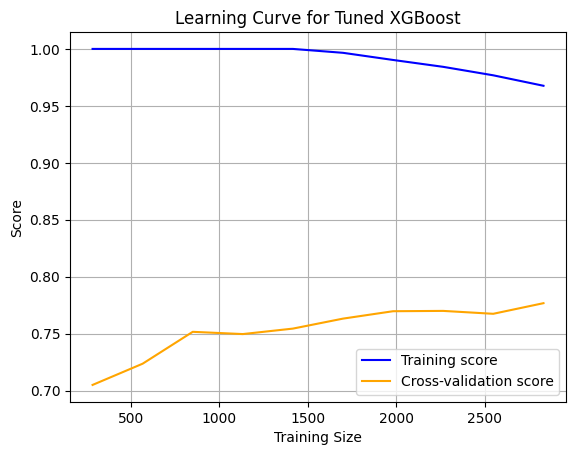

In [21]:
# Plot learning curve for the best XGBoost model
plot_learning_curve(best_xgb_model, X_train, y_train, title="Learning Curve for Tuned XGBoost")

In [22]:
# Using models without Hyperparameter tuning
rf_pipeline.fit(X_train, y_train)
xgb_pipeline.fit(X_train, y_train)

# Predictions on the Test Set
rf_y_pred1 = rf_pipeline.predict(X_test)
xgb_y_pred1 = xgb_pipeline.predict(X_test)

In [23]:
print("Random Forest Test Accuracy:", accuracy_score(y_test, rf_y_pred1))
print(classification_report(y_test, rf_y_pred1))

print("XGBoost Test Accuracy:", accuracy_score(y_test, xgb_y_pred1))
print(classification_report(y_test, xgb_y_pred1))

Random Forest Test Accuracy: 0.7661016949152543
              precision    recall  f1-score   support

           0       0.81      0.76      0.78       284
           1       0.53      0.33      0.40       159
           2       0.79      0.93      0.86       442

    accuracy                           0.77       885
   macro avg       0.71      0.67      0.68       885
weighted avg       0.75      0.77      0.75       885

XGBoost Test Accuracy: 0.7774011299435029
              precision    recall  f1-score   support

           0       0.81      0.76      0.79       284
           1       0.55      0.48      0.52       159
           2       0.83      0.89      0.86       442

    accuracy                           0.78       885
   macro avg       0.73      0.71      0.72       885
weighted avg       0.77      0.78      0.77       885



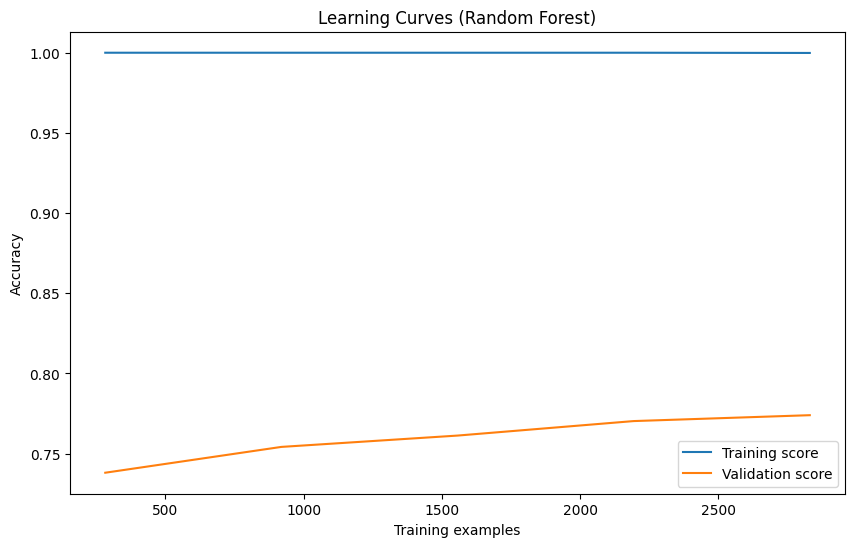

In [24]:
# Create learning curves for Random Forest
train_sizes, train_scores, test_scores = learning_curve(rf_pipeline, X_train, y_train, cv=5, scoring='accuracy')
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, test_scores_mean, label='Validation score')
plt.title('Learning Curves (Random Forest)')
plt.xlabel('Training examples')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


**Explanation of Model Performance**:

Overfitting: The Random Forest model is perfectly fitting the training data (high accuracy on training data), but it's not generalizing well on the validation data, which could imply overfitting. This is totally in contrast with the case of using hyperparameters to tune the model.

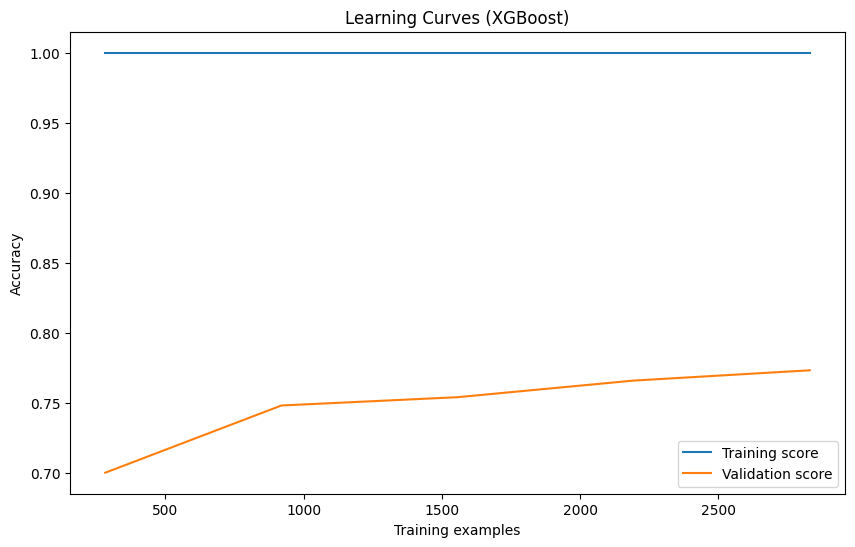

In [25]:
# Create learning curves for XGBoost
train_sizes, train_scores, test_scores = learning_curve(xgb_pipeline, X_train, y_train, cv=5, scoring='accuracy')
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, test_scores_mean, label='Validation score')
plt.title('Learning Curves (XGBoost)')
plt.xlabel('Training examples')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Explanation of Model Performance**:

Overfitting: The XGBoost model perfectly fits the training data (high accuracy on training data) as in the case of the Random Forest model, but it's not generalizing well on the validation data, which could imply overfitting. This is totally in contrast with the case of using hyperparameters to tune the model.



### Evaluating Best Random Forest  and xGBoost Models

In [26]:
# Predict with the best Random Forest model
rf_predictions = best_rf_model.predict(X_test)

# Predict with the best XGBoost model
xgb_predictions = best_xgb_model.predict(X_test)

In [27]:
# Evaluation for the best Random Forest model
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_report = classification_report(y_test, rf_predictions)
rf_confusion = confusion_matrix(y_test, rf_predictions)

print("Random Forest Model Evaluation:")
print("Accuracy:", rf_accuracy)
print("Classification Report:\n", rf_report)
print("Confusion Matrix:\n", rf_confusion)

Random Forest Model Evaluation:
Accuracy: 0.7796610169491526
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.75      0.78       284
           1       0.62      0.43      0.51       159
           2       0.80      0.93      0.86       442

    accuracy                           0.78       885
   macro avg       0.74      0.70      0.71       885
weighted avg       0.77      0.78      0.77       885

Confusion Matrix:
 [[212  23  49]
 [ 35  68  56]
 [ 14  18 410]]


In [28]:
# Evaluation for the best XGBoost model
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
xgb_report = classification_report(y_test, xgb_predictions)
xgb_confusion = confusion_matrix(y_test, xgb_predictions)

print("\nXGBoost Model Evaluation:")
print("Accuracy:", xgb_accuracy)
print("Classification Report:\n", xgb_report)
print("Confusion Matrix:\n", xgb_confusion)



XGBoost Model Evaluation:
Accuracy: 0.7728813559322034
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.74      0.77       284
           1       0.55      0.48      0.52       159
           2       0.82      0.90      0.86       442

    accuracy                           0.77       885
   macro avg       0.72      0.71      0.71       885
weighted avg       0.77      0.77      0.77       885

Confusion Matrix:
 [[210  36  38]
 [ 34  77  48]
 [ 18  27 397]]


### Feature selection using RFE on just the RF model

In [29]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 36 columns):
 #   Column                                          Non-Null Count  Dtype   
---  ------                                          --------------  -----   
 0   Marital status                                  4424 non-null   category
 1   Application mode                                4424 non-null   category
 2   Application order                               4424 non-null   category
 3   Course                                          4424 non-null   category
 4   Daytime/evening attendance                      4424 non-null   category
 5   Previous qualification                          4424 non-null   category
 6   Previous qualification (grade)                  4424 non-null   float64 
 7   Nationality                                     4424 non-null   category
 8   Mother_qualification                            4424 non-null   category
 9   Father_qualification          

In [30]:
# Initialize the Random Forest model
rf_model = best_rf_model.named_steps['model']

# Create the RFE object with the Random Forest model as the estimator
rfe = RFE(estimator=rf_model, n_features_to_select=15)  

# Fit RFE
rfe.fit(X_train, y_train)

# Get selected features
selected_features = X_train.columns[rfe.support_]

print("Selected Features:", selected_features)


Selected Features: Index(['Course', 'Previous qualification (grade)', 'Mother_occupation',
       'Admission grade', 'Tuition fees up to date', 'Age at enrollment',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)', 'GDP'],
      dtype='object')


In [31]:
# Train model with selected features
rf_model.fit(X_train[selected_features], y_train)

# Predict with test set
y_pred_rfe = rf_model.predict(X_test[selected_features])

# Evaluate the model
print("Random Forest Test Accuracy with RFE:", accuracy_score(y_test, y_pred_rfe))
print(classification_report(y_test, y_pred_rfe))

Random Forest Test Accuracy with RFE: 0.768361581920904
              precision    recall  f1-score   support

           0       0.80      0.75      0.78       284
           1       0.54      0.36      0.44       159
           2       0.80      0.92      0.86       442

    accuracy                           0.77       885
   macro avg       0.71      0.68      0.69       885
weighted avg       0.75      0.77      0.76       885



In [32]:
# Access the RandomForestClassifier from best model pipeline
rf_model = best_rf_model.named_steps['model']

# Apply RFE
rfe = RFE(estimator=rf_model, n_features_to_select=20)
rfe.fit(X_train, y_train)

# Get the selected features
selected_features2 = X_train.columns[rfe.support_]
print("Selected Features (RFE):", selected_features2)


Selected Features (RFE): Index(['Application mode', 'Course', 'Previous qualification (grade)',
       'Mother_occupation', 'Father_occupation', 'Admission grade',
       'Tuition fees up to date', 'Scholarship holder', 'Age at enrollment',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)', 'Unemployment rate',
       'Inflation rate', 'GDP'],
      dtype='object')


In [33]:
# Train the model with selected features
rf_model.fit(X_train[selected_features2], y_train)

# Predict with the test set
y_pred_rfe2 = rf_model.predict(X_test[selected_features2])

# Evaluate the model
print("Random Forest Test Accuracy with RFE:", accuracy_score(y_test, y_pred_rfe2))
print(classification_report(y_test, y_pred_rfe2))

Random Forest Test Accuracy with RFE: 0.7570621468926554
              precision    recall  f1-score   support

           0       0.81      0.72      0.76       284
           1       0.50      0.37      0.43       159
           2       0.79      0.92      0.85       442

    accuracy                           0.76       885
   macro avg       0.70      0.67      0.68       885
weighted avg       0.74      0.76      0.75       885



In [34]:
# Access the RandomForestClassifier from best model pipeline
rf_model = best_rf_model.named_steps['model']

# Apply RFE
rfe = RFE(estimator=rf_model, n_features_to_select=30)
rfe.fit(X_train, y_train)

# Get the selected features
selected_features3 = X_train.columns[rfe.support_]
print("Selected Features (RFE):", selected_features3)


Selected Features (RFE): Index(['Application mode', 'Application order', 'Course',
       'Previous qualification', 'Previous qualification (grade)',
       'Mother_qualification', 'Father_qualification', 'Mother_occupation',
       'Father_occupation', 'Admission grade', 'Displaced', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)', 'Unemployment rate',
       'Inflation rate', 'GDP'],
      dtype='object')


In [35]:
# Train the model with selected features
rf_model.fit(X_train[selected_features3], y_train)

# Predict with the test set
y_pred_rfe3 = rf_model.predict(X_test[selected_features3])

# Evaluate the model
print("Random Forest Test Accuracy with RFE:", accuracy_score(y_test, y_pred_rfe3))
print(classification_report(y_test, y_pred_rfe3))

Random Forest Test Accuracy with RFE: 0.7627118644067796
              precision    recall  f1-score   support

           0       0.78      0.75      0.76       284
           1       0.56      0.33      0.41       159
           2       0.79      0.93      0.85       442

    accuracy                           0.76       885
   macro avg       0.71      0.67      0.68       885
weighted avg       0.75      0.76      0.75       885



After applying hyperparameter tuning, our best Random Forest model achieved an accuracy of **78%**. After applying Recursive Feature Elimination (RFE) and selecting the **top 15 features**, we observed a slight drop in accuracy to **76.8%**. Despite this decrease, reducing the number of features is crucial as it helps mitigate overfitting, enhances model interpretability, and improves training efficiency. This analysis underscores the importance of a balanced approach to feature selection and model performance, paving the way for further improvements and refinements.

### using the selected features to train tuned RF model

In [36]:
# Defining selected categorical and numerical features
selected_categorical_cols = ['Course', 'Mother_occupation', 'Tuition fees up to date']
selected_numerical_cols = ['Previous qualification (grade)', 'Admission grade', 'Age at enrollment',
                           'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)',
                           'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)',
                           'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)',
                           'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'GDP']

In [37]:
# Updated the preprocessor for only selected features
preprocessor_selected = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', KNNImputer(n_neighbors=5)),
            ('scaler', StandardScaler())
        ]), selected_numerical_cols),
        ('cat', 'passthrough', selected_categorical_cols)
    ]
)

In [38]:
X[selected_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 15 columns):
 #   Column                                  Non-Null Count  Dtype   
---  ------                                  --------------  -----   
 0   Course                                  4424 non-null   category
 1   Previous qualification (grade)          4424 non-null   float64 
 2   Mother_occupation                       4424 non-null   category
 3   Admission grade                         4424 non-null   float64 
 4   Tuition fees up to date                 4424 non-null   category
 5   Age at enrollment                       4424 non-null   int64   
 6   Curricular units 1st sem (enrolled)     4424 non-null   int64   
 7   Curricular units 1st sem (evaluations)  4424 non-null   int64   
 8   Curricular units 1st sem (approved)     4424 non-null   int64   
 9   Curricular units 1st sem (grade)        4424 non-null   float64 
 10  Curricular units 2nd sem (enrolled)     4424 non

In [39]:
# Check if the number of columns matches
print("Number of columns:", X[selected_features].shape[1])

Number of columns: 15


In [40]:
# Recall Hyperparameter Search Spaces

# rf_param_dist = {
#     'model__n_estimators': [50, 100, 150],
#     'model__max_depth': [None, 5, 10, 15],
#     'model__min_samples_split': [4, 10, 20],
#     'model__min_samples_leaf': [2, 4, 6],
#     'model__bootstrap': [True, False]
# }

rf_param_dist = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth': [None, 5, 10, 15],
    'classifier__min_samples_split': [4, 10, 20],
    'classifier__min_samples_leaf': [2, 4, 6],
    'classifier__bootstrap': [True, False]
}

In [41]:
# Create the pipeline with a classifier
rf_pipeline2 = Pipeline(steps=[
    ('preprocessor', preprocessor_selected),
    ('classifier', RandomForestClassifier())
])

In [42]:
# Perform hyperparameter tuning with RandomizedSearchCV to the RandomForest pipeline
rf_random_search2 = RandomizedSearchCV(
    estimator=rf_pipeline2,
    param_distributions=rf_param_dist,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    n_iter=10,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

In [43]:
# Fit the model directly with preprocessed data
rf_pipeline2.fit(X[selected_features], y_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Previous qualification '
                                                   '(grade)',
                                                   'Admission grade',
                                                   'Age at enrollment',
                                                   'Curricular units 1st sem '
                                                   '(enrolled)',
                                                   'Curricular units 1st sem '
                                                   '(evaluations)',
                                                   'Curricular units 1st sem '
                                                   '(approved)',
                                                   'Curricular units 1st sem '
                                                   '(grade)',
                                                   'Curricular units 2nd sem '
                                                   '(enrolled)',
                                                   'Curricular units 2nd sem '
                                                   '(evaluations)',
                                                   'Curricular units 2nd sem '
                                                   '(approved)',
                                                   'Curricular units 2nd sem '
                                                   '(grade)',
                                                   'GDP']),
                                                 ('cat', 'passthrough',
                                                  ['Course',
                                                   'Mother_occupation',
                                                   'Tuition fees up to '
                                                   'date'])])),
                ('classifier', RandomForestClassifier())])

In [44]:
# Train Model with Hyperparameter Tuning
rf_random_search2.fit(X[selected_features], y_encoded)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                KNNImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['Previous '
                                                                                'qualification '
                                                                                '(grade)',
                                                                                'Admission '
                                                                                'grade',
                                                                                'Age '
                                                                                'at '
                                                                                'enrollment',
                                                                                'Curricular '
                                                                                'units '
                                                                                '1st '
                                                                                'sem '
                                                                                '(enrolled)',...
                                                                                'Tuition '
                                                                                'fees '
                                                                                'up '
                                                                                'to '
                                                                                'date'])])),
                                             ('classifier',
                                              RandomForestClassifier())]),
                   n_jobs=-1,
                   param_distributions={'classifier__bootstrap': [True, False],
                                        'classifier__max_depth': [None, 5, 10,
                                                                  15],
                                        'classifier__min_samples_leaf': [2, 4,
                                                                         6],
                                        'classifier__min_samples_split': [4, 10,
                                                                          20],
                                        'classifier__n_estimators': [50, 100,
                                                                     150]},
                   random_state=42, scoring='accuracy', verbose=1)

### Saving required pipelines

In [45]:
# Save the model pipeline (which includes the preprocessing steps)
joblib.dump(rf_random_search2, 'rf_pipeline_model.pkl')

# Save the LabelEncoder
joblib.dump(label_encoder, 'label_encoder.pkl')

print("Label Encoder and Model saved as label_encoder.pkl and rf_pipeline_model.pkl")

Label Encoder and Model saved as label_encoder.pkl and rf_pipeline_model.pkl
